In [1]:
# Instalacja Git do klonowania repozytorium z danymi.
# Instalacja konkretnych wersji scikeras i keras w celu uniknięcia problemów z kompatybilnością.
# Instalacja Optuna do optymalizacji hiperparametrów modelu.
!apt-get install git
!pip install scikeras==0.11.0 keras==2.15.0
!pip install optuna
!pip install optuna optuna-integration


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 2.3 MB/s eta 0:00:00


In [2]:
# Importowanie wszystkich potrzebnych bibliotek do przetwarzania danych, budowy modelu i optymalizacji.
# Użycie Pandas i Numpy do manipulacji danymi, TensorFlow do budowy sieci neuronowych,
# scikit-learn do przetwarzania danych i Optuna do optymalizacji hiperparametrów.
import pandas as pd
import numpy as np
import os
import optuna
import tensorflow as tf
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD, Nadam, Adamax
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau


In [3]:
# Klonowanie repozytorium z danymi pogodowymi i pożarowymi, które będą używane do trenowania modelu.
!git clone https://github.com/Kolszewski01/Datasets.git


Cloning into 'Datases'...
remote: Enumerating objects: 295, done.
remote: Counting objects: 100% (295/295), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 295 (delta 242), reused 292 (delta 242), pack-reused 0
Receiving objects: 100% (295/295), 10.36 MiB | 22.33 MiB/s, done.
Resolving deltas: 100% (242/242), done.


In [4]:
# Funkcja do wczytywania danych pogodowych.
# Wczytuje pliki CSV z danymi pogodowymi z podanej ścieżki repozytorium.
# Pliki te są następnie łączone w jeden DataFrame.

def load_weather_data(repo_path):
    weather_headers = [
        "Kod stacji", "Nazwa stacji", "Rok", "Miesiąc", "Dzień",
        "Średnia dobowa temperatura [°C]", "Status pomiaru TEMP",
        "Średnia dobowa wilgotność względna [%]", "Status pomiaru WLGS",
        "Średnia dobowa prędkość wiatru [m/s]", "Status pomiaru FWS",
        "Średnie dobowe zachmurzenie ogólne [oktanty]", "Status pomiaru NOS"
    ]
    weather_path = os.path.join(repo_path, 'Pogoda')
    weather_dataframes = []

    for filename in os.listdir(weather_path):
        file_path = os.path.join(weather_path, filename)
        if filename.endswith('.csv'):
            df = pd.read_csv(file_path, encoding='cp1250', names=weather_headers)
            weather_dataframes.append(df)

    weather_df = pd.concat(weather_dataframes, ignore_index=True)
    return weather_df

# Funkcja do wczytywania danych o pożarach.
# Wczytuje pliki CSV z danymi o pożarach z podanej ścieżki repozytorium.
# Pliki te są następnie łączone w jeden DataFrame.

def load_fire_data(repo_path):
    fire_path = os.path.join(repo_path, 'Pozary')
    fire_dataframes = []

    for filename in os.listdir(fire_path):
        file_path = os.path.join(fire_path, filename)
        if filename.endswith('.csv'):
            df = pd.read_csv(file_path, encoding='cp1250')
            fire_dataframes.append(df)

    fire_df = pd.concat(fire_dataframes, ignore_index=True)
    return fire_df

# Funkcja do przetwarzania danych pogodowych.
# Dodaje kolumnę z datą, usuwa niepotrzebne kolumny i przekształca dane do odpowiedniego formatu.
# Filtruje dane, aby usunąć wiersze z zerową wilgotnością.

def preprocess_weather_data(weather_df):
    weather_df['Data'] = weather_df[weather_df.columns[2:5]].apply(lambda x: '-'.join(x.dropna().astype(str)), axis=1)
    weather_df.drop(columns=['Nazwa stacji','Kod stacji','Rok','Miesiąc','Dzień','Status pomiaru NOS',
                             'Średnie dobowe zachmurzenie ogólne [oktanty]','Status pomiaru FWS',
                             'Średnia dobowa prędkość wiatru [m/s]','Status pomiaru WLGS','Status pomiaru TEMP'],
                    inplace=True)
    weather_df['Data'] = weather_df['Data'].apply(lambda x: '-'.join([part.zfill(2) for part in x.split('-')]))
    weather_df['Data'] = pd.to_datetime(weather_df['Data'], format='%Y-%m-%d')
    weather_df = weather_df[weather_df['Średnia dobowa wilgotność względna [%]'] != 0.0]
    return weather_df

# Funkcja do przetwarzania danych o pożarach.
# Usuwa niepotrzebne kolumny i przekształca dane do odpowiedniego formatu.
# Grupuje dane według daty, aby zliczyć pożary każdego dnia.

def preprocess_fire_data(fire_df):
    fire_df.drop(columns=['brightness','scan','track','acq_time','satellite','instrument','confidence',
                          'version','bright_t31','frp','daynight','latitude','longitude'], inplace=True)
    fire_df = fire_df[fire_df['type'] == 0]
    fire_df.rename(columns={'acq_date':'Data','type':'Typ'}, inplace=True)
    fire_df = fire_df.groupby('Data', as_index=False).size()
    fire_df['Data'] = pd.to_datetime(fire_df['Data'], format='%Y-%m-%d')
    return fire_df

# Funkcja do łączenia danych pogodowych i danych o pożarach.
# Łączy oba zestawy danych na podstawie kolumny z datą.
# Dodaje kolumnę wskazującą, czy danego dnia wystąpił pożar.

def combine_data(weather_df, fire_df):
    df_combined = pd.merge(weather_df, fire_df, on='Data', how='left')
    df_combined.rename(columns={'size': 'Pozar'}, inplace=True)
    df_combined.fillna(0, inplace=True)
    df_combined['Pozar'] = np.where(df_combined['Pozar'] > 0, 1, 0)
    return df_combined

# Funkcja do wyboru metody skalowania danych.
# Wybiera MinMaxScaler lub StandardScaler w zależności od podanego argumentu.

def select_scaler(method='standardization'):
    if method == 'normalization':
        return MinMaxScaler()
    else:
        return StandardScaler()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
# Wczytywanie danych pogodowych i pożarowych oraz ich przetwarzanie.
# Łączenie przetworzonych danych w jedną tabelę.
# Podział danych na zestaw treningowy i testowy.

repo_path = 'Datases/POZARY_POGODA'

weather_df = load_weather_data(repo_path)
fire_df = load_fire_data(repo_path)

weather_df = preprocess_weather_data(weather_df)
fire_df = preprocess_fire_data(fire_df)

df_combined = combine_data(weather_df, fire_df)

X = df_combined.drop(columns=['Data', 'Pozar'])
y = df_combined['Pozar']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<ipython-input-4-2795a3c29cec>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_df.rename(columns={'acq_date':'Data','type':'Typ'}, inplace=True)


In [6]:
# Definicja klasy DataFrameSelector, która wybiera określone kolumny z danych.
# Ta klasa będzie używana w potoku przetwarzania danych, aby wybrać tylko te kolumny, które są istotne dla modelu.
# Klasa ta implementuje metody fit i transform, wymagane przez scikit-learn do wbudowania jej w potok przetwarzania danych.

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names]

# Tworzenie funkcji create_model, która buduje model Keras z użyciem parametrów sugerowanych przez Optuna.
# Funkcja ta tworzy sieć neuronową z liczbą warstw i jednostek w każdej warstwie zależną od parametrów sugerowanych przez Optuna.
# Używa różnych optymalizatorów (Adam, SGD, Nadam, Adamax), aby znaleźć najlepszy dla danego zadania.
# Model jest kompilowany z funkcją straty 'binary_crossentropy' i metryką 'accuracy'.

def create_model(trial, input_dim):
    model = Sequential()

    # Sugerowanie liczby warstw ukrytych (1 do 3) przez Optuna
    n_layers = trial.suggest_int('n_layers', 1, 3)

    # Sugerowanie liczby jednostek w pierwszej warstwie (50 do 200) przez Optuna
    units = trial.suggest_int('units_l0', 10, 200)
    model.add(Dense(units, input_dim=input_dim, activation='relu'))

    # Dodawanie kolejnych warstw ukrytych na podstawie liczby warstw sugerowanych przez Optuna
    for i in range(1, n_layers):
        units = trial.suggest_int(f'units_l{i}', 50, 200)
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(trial.suggest_float(f'dropout_l{i}', 0.1, 0.5)))

    # Dodawanie warstwy wyjściowej z aktywacją sigmoid, ponieważ jest to problem binarnej klasyfikacji
    model.add(Dense(1, activation='sigmoid'))

    # Sugerowanie optymalizatora przez Optuna (Adam, SGD, Nadam, Adamax)
    optimizer_options = {'adam': Adam, 'sgd': SGD, 'nadam': Nadam, 'adamax': Adamax}
    optimizer_name = trial.suggest_categorical('optimizer', list(optimizer_options.keys()))
    optimizer = optimizer_options[optimizer_name]()

    # Kompilacja modelu z funkcją straty 'binary_crossentropy' i metryką 'accuracy'
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Definicja harmonogramu uczenia, aby zmieniać szybkość uczenia w trakcie treningu.
# Funkcja scheduler zmniejsza szybkość uczenia o wykładnik 0.1 po 10 epokach.
# Pozwala to na bardziej stabilne uczenie modelu po początkowej fazie szybkiego uczenia.

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Funkcja create_pipeline tworzy potok przetwarzania danych i trenowania modelu.
# Potok ten składa się z trzech kroków: wybór cech, skalowanie danych, trenowanie modelu.
# Używa DataFrameSelector do wyboru odpowiednich kolumn, StandardScaler do skalowania danych i KerasClassifier do trenowania modelu.
# Parametry modelu (np. liczba epok, wielkość batcha) są sugerowane przez Optuna.

def create_pipeline(trial):
    pipeline = Pipeline([
        ('select_features', DataFrameSelector(attribute_names=[
            "Średnia dobowa temperatura [°C]",
            "Średnia dobowa wilgotność względna [%]"
        ])),
        ('scaler', StandardScaler()),
        ('classifier', KerasClassifier(
            model=create_model,
            model__trial=trial,
            model__input_dim=2,
            batch_size=trial.suggest_int('batch_size', 16, 64),
            epochs=50,
            verbose=0
        ))
    ])
    return pipeline


In [7]:
# Definicja funkcji celu dla Optuna, która buduje model z użyciem potoku i optymalizuje jego hiperparametry.
# Wykorzystanie Optuna do znalezienia najlepszych parametrów modelu.
# Wykorzystanie EarlyStopping i LearningRateScheduler jako callbacków podczas trenowania.

def objective(trial):
    pipeline = create_pipeline(trial)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    lr_scheduler = LearningRateScheduler(scheduler)

    pipeline.fit(X_train, y_train)

    score = pipeline.score(X_test, y_test)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, n_jobs=-1)

print("Najlepsze parametry: ", study.best_params)
print("Najlepsza dokładność: ", study.best_value)


[I 2024-06-03 15:13:13,073] A new study created in memory with name: no-name-dc11179a-492d-4d7d-9336-129ea005341a
[I 2024-06-03 15:30:48,720] Trial 1 finished with value: 0.7218157692916357 and parameters: {'batch_size': 64, 'n_layers': 2, 'units_l0': 20, 'units_l1': 84, 'dropout_l1': 0.30896703029701966, 'optimizer': 'nadam'}. Best is trial 1 with value: 0.7218157692916357.
[I 2024-06-03 15:50:22,685] Trial 2 finished with value: 0.7231670054901579 and parameters: {'batch_size': 56, 'n_layers': 3, 'units_l0': 38, 'units_l1': 105, 'dropout_l1': 0.1538119412879896, 'units_l2': 97, 'dropout_l2': 0.14767488002191653, 'optimizer': 'sgd'}. Best is trial 2 with value: 0.7231670054901579.
[I 2024-06-03 16:11:57,894] Trial 0 finished with value: 0.7233739515746163 and parameters: {'batch_size': 18, 'n_layers': 3, 'units_l0': 184, 'units_l1': 190, 'dropout_l1': 0.397013634699948, 'units_l2': 131, 'dropout_l2': 0.3558558738300823, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.72337395157461

Najlepsze parametry:  {'batch_size': 39, 'n_layers': 3, 'units_l0': 192, 'units_l1': 146, 'dropout_l1': 0.14662037977900413, 'units_l2': 182, 'dropout_l2': 0.19189009136364318, 'optimizer': 'adamax'}
Najlepsza dokładność:  0.7236904573508467


In [8]:
# Budowanie najlepszego modelu z użyciem najlepszych parametrów znalezionych przez Optuna.
# Trenowanie modelu z użyciem całego zestawu treningowego i najlepszych parametrów.
# Wyświetlanie raportu z klasyfikacji.

best_trial = study.best_trial
best_pipeline = create_pipeline(best_trial)
best_pipeline.fit(X_train, y_train)

y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype("int32") # przekształcenia prawdopodobieństw predykcji na konkretne etykiety klas (0 lub 1).
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.77      0.80      0.78     51313
           1       0.64      0.60      0.62     30834

    accuracy                           0.72     82147
   macro avg       0.70      0.70      0.70     82147
weighted avg       0.72      0.72      0.72     82147



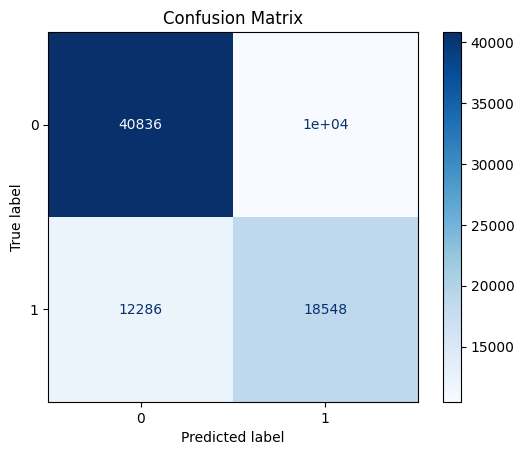

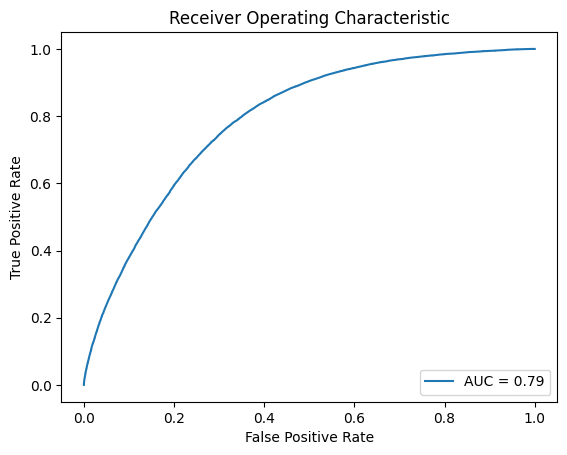

Accuracy: 0.7228991929102706


In [9]:
# Importowanie bibliotek potrzebnych do wizualizacji wyników modelu.
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay

# Predykcje i obliczenia wyników modelu.
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype("int32")

# Wyświetlanie macierzy pomyłek za pomocą ConfusionMatrixDisplay.
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Wyświetlanie krzywej ROC za pomocą RocCurveDisplay.
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_disp.plot()
plt.title('Receiver Operating Characteristic')
plt.show()

# Wyświetlanie dokładności modelu.
evaluation = best_pipeline.score(X_test, y_test)
print(f'Accuracy: {evaluation}')


1. Macierz Pomyłek:

Macierz pomyłek przedstawia porównanie przewidywań modelu z rzeczywistymi wynikami.

True Negative (TN): 40836 - Liczba prawdziwie negatywnych przewidywań, gdzie model poprawnie zidentyfikował brak pożaru.


False Positive (FP): 10000 - Liczba fałszywie pozytywnych przewidywań, gdzie model błędnie przewidział pożar, który nie miał miejsca.


False Negative (FN): 12286 - Liczba fałszywie negatywnych przewidywań, gdzie model nie wykrył pożaru, który faktycznie miał miejsce.


True Positive (TP): 18548 - Liczba prawdziwie pozytywnych przewidywań, gdzie model poprawnie zidentyfikował pożar.


2. Krzywa ROC:

Krzywa ROC przedstawia zależność pomiędzy True Positive Rate (TPR) a False Positive Rate (FPR) dla różnych progów decyzyjnych modelu.

AUC (Area Under Curve): 0.79 - Wartość AUC wynosząca 0.79 wskazuje na dobrą zdolność modelu do rozróżniania między klasami.

3. Dokładność Modelu (Accuracy):

Accuracy: 0.77 - Model poprawnie klasyfikuje 77% wszystkich przykładów w zestawie testowym.